# Oscillation analysis for WME-face-jitter

## Setup

In [106]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import scipy.stats as stats
import ast
from scipy.stats import norm, uniform
# from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from math import pi
from itertools import combinations
import glob
import re
import random

In [60]:
def chunk_list(input_list, chunk_size):
    """Splits the list into chunks of specified size."""
    return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

def convert_string_to_numbers(row_string):
    # Use regular expression to find all numerical parts in the string
    numbers = [int(num) for num in re.findall(r'\d+', row_string)]
    return numbers

def accuracy_with_order(user_responses, correct_answers):
    accuracies = []
    for user_resp, correct_ans in zip(user_responses, correct_answers):
        correct_count = sum(u == c for u, c in zip(user_resp, correct_ans))
        accuracy = correct_count / len(correct_ans)
        accuracies.append(accuracy)
    return accuracies

def accuracy_without_order(user_responses, correct_answers):
    accuracies = []
    for user_resp, correct_ans in zip(user_responses, correct_answers):
        correct_count = sum(user_resp.count(c) for c in set(correct_ans))
        accuracy = correct_count / len(correct_ans)
        accuracies.append(accuracy)
    return accuracies

def convert_to_floats(str_list):
    float_list = []
    for s in str_list:
        # Use ast.literal_eval to safely evaluate the string as a list
        # Then convert each element in the resulting list to a float
        floats = ast.literal_eval(s)
        float_list.extend(floats if isinstance(floats, list) else [floats])
    return float_list

# Updated function that extracts only the first float from each string
def convert_to_floats(str_list):
    float_list = []
    for s in str_list:
        # Use ast.literal_eval to safely evaluate the string as a list
        # Then convert each element in the resulting list to a float
        floats = ast.literal_eval(s)
        float_list.extend(floats if isinstance(floats, list) else [floats])
    return float_list

def convert_strings_to_float_lists(str_list):
    float_lists = []
    for s in str_list:
        if s == "None": 
            float_lists.append(s)
        else:
        # Convert the string representation of list to actual list and then to floats
            float_list = [float(x) for x in ast.literal_eval(s)]
            float_lists.append(float_list)
    return float_lists

def chunk_list(lst, n):
        chunked_list = []
        for i in range(0, len(lst), n):
            chunked_list.append(lst[i:i + n])
        return chunked_list

def has_common_letter(pair1, pair2):
        return any(letter in pair2 for letter in pair1)

def convert_to_float_list(series):
    float_list = []
    for value in series:
        if isinstance(value, str):  # Check if the value is a string
            float_list.append([float(i) for i in value.strip("[]").split(",")][0])  # Convert string to float and remove brackets
        elif isinstance(value, list):  # Check if the value is a list
            float_list.extend([float(v) for v in value])  # Convert each element of the list to float
        else:  # Handle NaN values
            float_list.append(float('nan'))  # Append NaN if value is NaN
    return float_list

def compute_precision_acc(data):
    num = data['pressed_num']
    corr = data['num']
    congruent = data['congruent']
    if congruent == 1:
        if 2 <= corr <= 9:
            return 1 if num in {corr - 1, corr, corr + 1} else 0
        elif corr == 1:
            return 1 if num in {10, 1, 2} else 0
        elif corr == 10:
            return 1 if num in {9, 10, 1} else 0
    elif congruent == 0:
        if 1 <= corr <= 4:
            return 1 if num in {corr + 5 - 1, corr + 5, corr + 5 + 1} else 0
        elif corr == 5:
            return 1 if num in {9, 10, 1} else 0
        elif corr == 6:
            return 1 if num in {10, 1, 2} else 0
        elif 7 <= corr <= 10:
            return 1 if num in {corr - 5 - 1, corr - 5, corr - 5 + 1} else 0

def transac(din, n, sc=None):
    """
    Arcsine transform of relative frequencies (Winer, 1971)
    
    Parameters:
        din (array-like): Data vector
        n (int): Sample size
        sc (int, optional): Scale (0: [0, 1], 1: [0, 100])
    
    Returns:
        dout (ndarray): Transformed data vector
    """
    
    # Convert data to numpy array
    din = np.array(din)
    
    # Scale conversion if necessary
    if sc == 1:
        din = din / 100
    
    # Define upper and lower limits
    upperlim = 1 - 1 / (2 * n)
    lowerlim = 1 / (2 * n)
    
    # Initialize output array
    dout = np.zeros_like(din)
    
    # Apply transformation
    for i in range(len(din)):
        if din[i] < lowerlim:
            dout[i] = 2 * np.arcsin(np.sqrt(lowerlim))
        elif din[i] > upperlim:
            dout[i] = 2 * np.arcsin(np.sqrt(upperlim))
        else:
            dout[i] = 2 * np.arcsin(np.sqrt(din[i]))
    
    return dout

def replace_outliers_with_nan(df, sd_thresh = 3):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            mean = df[column].mean()
            std = df[column].std()
            threshold_upper = mean + sd_thresh * std
            threshold_lower = mean - sd_thresh * std
            
            # Replace outliers with NaN
            df[column] = df[column].apply(lambda x: np.nan if (x > threshold_upper or x < threshold_lower) else x)
    return df

def drop_rows_with_most_nans(df):
    # Identify the column with the most NaN values
    column_with_most_nans = df.isna().sum().idxmax()
    
    # Drop rows where that column has NaN values
    df = df.dropna(subset=[column_with_most_nans])
    
    return df

In [61]:
def norm_recall_counts(data, col = "similarity"):
    coeff_dict = dict()
    for ind in data[col].value_counts().index:
        coeff_dict[ind] = data[col].value_counts()[ind] / len(data)
    return coeff_dict

def convert_to_float_list(series):
    float_list = []
    for value in series:
        if isinstance(value, str):
            if "," in value.strip("[]"):
                float_list.append([float(v) for v in value.strip("[]").split(",")][0])# Check if the value is a string
            else:
                float_list.append(float(value.strip("[]")))  # Convert string to float and remove brackets
        elif isinstance(value, list):  # Check if the value is a list
            float_list.extend([float(v) for v in value])  # Convert each element of the list to float
        else:  # Handle NaN values
            float_list.append(float('nan'))  # Append NaN if value is NaN
    return float_list

def box_and_whisker_simple(data, fdr = False):
    """
    Create a box-and-whisker plot with significance bars.
    """
    fig, ax = plt.subplots(figsize=(8,6))
    bp = ax.boxplot(data, widths=0.6, patch_artist=True)
    # Graph title
    # ax.set_title(title, fontsize=14)
    ax.grid(axis='x')
    ax.tick_params(axis='x', which='major', length=0)
    # Show x-axis minor ticks
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks, minor=True)
    # Clean up the appearance
    ax.tick_params(axis='x', which='minor', length=3, width=1)

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    colors = sns.color_palette()
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Colour of the median lines
    plt.setp(bp['medians'], color='k')

    # Check for statistical significance
    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    # data = data.transpose().to_numpy()
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    p_values = []
    for c in combinations:
        data1 = data[c[0] - 1]
        data2 = data[c[1] - 1]
        # Significance
        U, p = stats.ttest_rel(data1, data2)
        p_values.append(p)
        # if p < 0.05:
        significant_combinations.append([c, p])
    if fdr:
        p_adj = stats.false_discovery_control(p_values, method="by")
    else:
        p_adj = np.array(p_values)
    
    mask = p_adj < 0.05
    
    p_adj = [value for value, mask_value in zip(p_adj, mask) if mask_value]
    significant_combinations = [value for value, mask_value in zip(significant_combinations, mask) if mask_value]
    assert (len(p_adj) == len(significant_combinations)), "Check your data length!"
    
    for i in range(len(p_adj)):
        significant_combinations[i][1] = p_adj[i]
    # Get info about y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom

    # Significance bars
    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '** p={}'.format(np.round(p, 4))
        elif p < 0.05:
            sig_symbol = '* p={}'.format(np.round(p, 4))
        else:
            sig_symbol = 'p={}'.format(np.round(p, 4))
        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top)


from itertools import combinations

def generate_pairs(elements):
    """
    Generate tuples of all possible pairs from a list of elements without repeats.
    
    Parameters:
        elements (list): List of elements from which pairs are generated.
        
    Returns:
        list of tuples: List containing tuples of all possible pairs.
    """
    pairs = list(combinations(elements, 2))
    return pairs

def convert_df_to_arr(dataframe):
    data = []
    data_labels = []
    for col in dataframe.columns:
        data.append(dataframe[col].to_numpy())
        data_labels.append(col)
    return data, data_labels

In [62]:
import glob
import re
pd.options.mode.chained_assignment = None
n_blocks = 10
n_trials = 40
subsets = []
path = "/Users/fzaki001/Documents/AHC5-rooms/WME/wme-face-jitter/data/"
path_pic = '/Users/fzaki001/Documents/DA/wme-face-jitter/'
pattern = r'\d+'
subjects = sorted([re.search(pattern, i)[0] for i in os.listdir(path) if (i.endswith("csv") and "SCRD" not in i)])

def convert_to_float_list_multiple(series):
    float_list = []
    for value in series:
        if isinstance(value, str):
            if "," in value.strip("[]"):
                float_list.append([float(v) for v in value.strip("[]").split(",")])# Check if the value is a string
            else:
                float_list.append(float(value.strip("[]")))  # Convert string to float and remove brackets
        elif isinstance(value, list):  # Check if the value is a list
            float_list.extend([float(v) for v in value])  # Convert each element of the list to float
        else:  # Handle NaN values
            float_list.append(float('nan'))  # Append NaN if value is NaN
    return float_list

  9%|██▎                        | 4/46 [00:00<00:02, 17.70it/s]

sub-280173 checked
sub-280174 checked
sub-280175 checked
sub-280176 checked
sub-280177 checked
sub-280178 checked


 24%|██████▏                   | 11/46 [00:00<00:01, 27.17it/s]

sub-280179 checked
sub-280181 checked
sub-280182 checked
sub-280183 checked
sub-280184 checked
sub-280185 checked
sub-280186 checked
sub-280189 checked
sub-280194 checked


 50%|█████████████             | 23/46 [00:00<00:00, 34.81it/s]

sub-280195 checked
sub-280196 checked
sub-280201 checked
sub-280204 checked
sub-280207 checked
sub-280209 checked
sub-280211 checked
sub-280213 checked


 61%|███████████████▊          | 28/46 [00:00<00:00, 37.15it/s]

sub-280214 checked
sub-280215 checked
sub-280216 checked
sub-280217 checked
sub-280218 checked
sub-280219 checked
sub-280220 checked
sub-280222 checked
sub-280224 checked


 80%|████████████████████▉     | 37/46 [00:01<00:00, 38.40it/s]

sub-280226 checked
sub-280227 checked
sub-280228 checked
sub-280229 checked
sub-280230 checked
sub-280231 checked
sub-280234 checked
sub-280235 checked
sub-280237 checked


100%|██████████████████████████| 46/46 [00:01<00:00, 33.68it/s]


sub-280238 checked
sub-280240 checked
sub-280241 checked
sub-280243 checked
sub-280244 checked


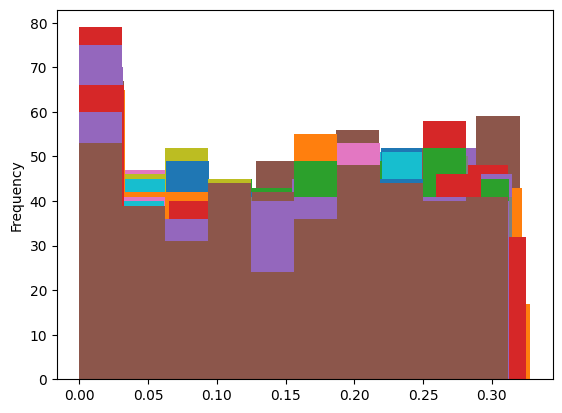

In [63]:
trial_data_list = []
sanity_check = {
    "less_200ms": [],
    "2_or_more": [],
    "3_plus": [],
}
from tqdm import tqdm
normalize = True
face_task_dict = {
    "sub": [],
    "fl_acc": [],
    "fl_acc_con": [],
    "fl_acc_incon": [],
    "wm_acc": [],
    "con_rt_corr": [],
    "incon_rt_corr": [],
    "con_rt_incor": [],
    "incon_rt_incor": [],
    "skipped_fl": [],
    "recall_rt": [],
    "recall_rt_std": [],
    "skipped_recall": [],
    "recall_mean": [],
    "recall_corr": [],
    "recall_corr_paired": [],
    "recall_corr_L": [],
    "recall_corr_R": [],
    "recall_err": [],
    "recall_err_paired": [],
    "recall_err_L": [],
    "recall_err_R": [],
    "recall_con": [],
    "recall_con_L": [],
    "recall_con_R": [],
    "recall_incon": [],
    "recall_incon_L": [],
    "recall_incon_R": [],
    "recall_L": [],
    "recall_R": [],
    1: [],
    2: [],
    3: [],
    
    "1_r":[],
    "2_r":[],
    "3_r":[],
    
    "1_corr": [],
    "2_corr": [],
    "3_corr": [],
    
    "1_err": [],
    "2_err": [],
    "3_err": [],

    "1_con": [],
    "2_con": [],
    "3_con": [],

    "1_incon": [],
    "2_incon": [],
    "3_incon": [],
}

value_counts = 0

for sub in tqdm(subjects):
    pattern = "{}sub-{}*_wme-face*.csv".format(path, sub)
    filename = glob.glob(pattern)
    # wm_df = pd.DataFrame()
    data = pd.read_csv(filename[0])
    start_index = data["flanker_acc"].first_valid_index()
    data = data.iloc[start_index:].reset_index(drop = True)
    data["real_jitter"] = data["prime_face.started"] - data["task_fixImg_4.started"]
    # data["recall_resp_debug.keys"].value_counts().plot(kind = 'bar')
    prepotent_rt_multiple = convert_to_float_list_multiple(data["recall_resp_debug.rt"].dropna())
    prepotent_rt = convert_to_float_list(data["recall_resp_debug.rt"].dropna())
    sanity_check["less_200ms"]\
    .append(len([i for i in prepotent_rt if i<=0.2]))
    sanity_check["2_or_more"]\
    .append(len([i for i in prepotent_rt_multiple if (isinstance(i, list) and len(i) >= 2)]))
    sanity_check["3_plus"]\
    .append(len([i for i in prepotent_rt_multiple if (isinstance(i, list) and len(i) > 3)]))
    data["real_jitter"].plot(kind="hist")
    trial_data = data[
    [
    "target",
    "flanker_acc",
    "congruent",
    "flanker_face_resp.rt",
    "recall_resp.rt",
    "prime",
    "recall",
    "similarity",
    "real_jitter",
    "prime_jitter",
    ]
    ].replace(to_replace=['None'], value=np.nan).dropna(subset = "congruent").reset_index(drop = True)
    trial_data.columns = ["target", "acc", "congruent", "fl_rt", "recall_rt", "prime", "recall", "similarity", "jitter", "prime_jitter"]
    trial_data[["recall", "similarity"]] = trial_data[["recall", "similarity"]].astype(float)

    trial_data["fl_rt"] = convert_to_float_list(trial_data.fl_rt)
    trial_data["recall_rt"] = convert_to_float_list(trial_data.recall_rt)

    fl_data = trial_data.copy()
    # face_task_dict["fl_acc"].append(fl_data.acc.mean())
    face_task_dict["skipped_fl"].append(fl_data.fl_rt.isna().sum())
    face_task_dict["skipped_recall"].append(fl_data.recall_rt.isna().sum())
    
    fl_data = fl_data.dropna(subset = "fl_rt").reset_index(drop = True)
    fl_data = fl_data[fl_data["fl_rt"] > 0.150].reset_index(drop = True)
    
    face_task_dict["con_rt_corr"].append(fl_data[(fl_data["congruent"] == 1) & (fl_data["acc"] == 1)].fl_rt.mean())
    face_task_dict["incon_rt_corr"].append(fl_data[(fl_data["congruent"] == 0) & (fl_data["acc"] == 1)].fl_rt.mean())
    face_task_dict["con_rt_incor"].append(fl_data[(fl_data["congruent"] == 1) & (fl_data["acc"] == 0)].fl_rt.mean())
    face_task_dict["incon_rt_incor"].append(fl_data[(fl_data["congruent"] == 0) & (fl_data["acc"] == 0)].fl_rt.mean())

    face_task_dict["fl_acc"].append(fl_data.acc.mean())
    face_task_dict["fl_acc_con"].append(fl_data[fl_data["congruent"] == 1].acc.mean())
    face_task_dict["fl_acc_incon"].append(fl_data[fl_data["congruent"] == 0].acc.mean())

    wm_acc_data = trial_data.dropna(subset = "recall").reset_index(drop = True)
    face_task_dict["wm_acc"].append(len(wm_acc_data[wm_acc_data["similarity"] == 2])/len(wm_acc_data))

    trial_data = trial_data.dropna(subset = "fl_rt").reset_index(drop = True)
    trial_data = trial_data.dropna(subset = "recall").reset_index(drop = True)
    trial_data["prime"] = trial_data["prime"].apply(lambda x: "L" if x == 6 else ("R" if x == 14 else None))
    trial_data = trial_data[trial_data["fl_rt"] > 0.150].reset_index(drop = True)
    trial_data["sub"] = sub
    trial_data_list.append(trial_data)
    
    trial_types = ["all", "corr", "incorr", "left", "right", "con", "incon"] 
    trial_data.loc[trial_data["prime"] == "L", "similarity"] = 4 - trial_data.loc[trial_data["prime"] == "L", "similarity"]

    assert np.sum(list(trial_data[trial_data["fl_rt"] < 0.150]["fl_rt"])) == 0, "Check your flanker RT!"
    assert np.sum(list(trial_data[trial_data["fl_rt"] > 0.7]["fl_rt"])) == 0, "Check your flanker RT!"
    assert np.sum([type(i) != float for i in trial_data["fl_rt"]]) == 0, "Check your flanker RT!"
    assert np.sum([type(i) != float for i in trial_data["recall_rt"]]) == 0, "Check your recall RT!"
    assert np.sum(list(trial_data[trial_data["recall_rt"] > 3]["recall_rt"])) == 0, "Check your recall RT!"
    assert np.sum(list(trial_data.isna().sum())) == 0, "Check data for NaN!"
    
    print("sub-{} checked".format(sub))
    
    face_task_dict["recall_corr"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 0)].similarity.mean())
    face_task_dict["recall_corr_R"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 0)\
                                           & (trial_data["prime"] == "R")].similarity.mean())
    face_task_dict["recall_corr_L"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 0)\
                                           & (trial_data["prime"] == "L")].similarity.mean())

    if len(trial_data[(trial_data["acc"] == 0) & (trial_data["congruent"] == 0) & (trial_data["prime"] == "R")]) >= 6:
        face_task_dict["recall_err_R"].append(trial_data[(trial_data["acc"] == 0) & (trial_data["congruent"] == 0)\
                                             & (trial_data["prime"] == "R")].similarity.mean())
    else:
        face_task_dict["recall_err_R"].append(np.nan)

    if len(trial_data[(trial_data["acc"] == 0) & (trial_data["congruent"] == 0) & (trial_data["prime"] == "L")]) >= 6:
        face_task_dict["recall_err_L"].append(trial_data[(trial_data["acc"] == 0) & (trial_data["congruent"] == 0)\
                                             & (trial_data["prime"] == "L")].similarity.mean())
    else:
        face_task_dict["recall_err_L"].append(np.nan)

    if len(trial_data[(trial_data["acc"] == 0) & (trial_data["congruent"] == 0)]) >= 6:
        face_task_dict["recall_err"].append(trial_data[(trial_data["acc"] == 0) & (trial_data["congruent"] == 0)].similarity.mean())

    else:
        face_task_dict["recall_err"].append(np.nan)

    face_task_dict["recall_con"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 1)].similarity.mean())
    face_task_dict["recall_con_R"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 1)\
                                          & (trial_data["prime"] == "R")].similarity.mean())
    face_task_dict["recall_con_L"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 1)\
                                          & (trial_data["prime"] == "L")].similarity.mean())

    face_task_dict["recall_incon"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 0)].similarity.mean())
    face_task_dict["recall_incon_R"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 0)\
                                            & (trial_data["prime"] == "R")].similarity.mean())
    face_task_dict["recall_incon_L"].append(trial_data[(trial_data["acc"] == 1) & (trial_data["congruent"] == 0)\
                                            & (trial_data["prime"] == "L")].similarity.mean())

    face_task_dict["recall_L"].append(trial_data[trial_data["prime"] == "L"].similarity.mean())

    face_task_dict["recall_R"].append(trial_data[trial_data["prime"] == "R"].similarity.mean())

    face_task_dict["recall_mean"].append(trial_data.similarity.mean())
    
    
    face_task_dict["recall_rt"].append(trial_data.recall_rt.mean()+1)
    face_task_dict["recall_rt_std"].append(trial_data.recall_rt.std())

    err_inds = []
    for i in range(len(trial_data)):
        if i > 1:
            if (trial_data.acc[i] == 0 and trial_data.congruent[i] == 0)\
            and (trial_data.acc[i-1] == 1 and trial_data.congruent[i-1] == 0):
                err_inds.append(i-1)
                err_inds.append(i)
    error_data = trial_data.iloc[err_inds]
    if (len(error_data[error_data["acc"] == 1]) >= 6 and len(error_data[error_data["acc"] == 0]) >= 6):
        face_task_dict["recall_err_paired"].append(error_data[error_data["acc"] == 0].similarity.mean())
        face_task_dict["recall_corr_paired"].append(error_data[error_data["acc"] == 1].similarity.mean())
    else: 
        face_task_dict["recall_err_paired"].append(np.nan)
        face_task_dict["recall_corr_paired"].append(np.nan)
    
    if normalize:
        norms = norm_recall_counts(trial_data, "similarity")
        face_task_dict[1].append(norms[1])
        face_task_dict[2].append(norms[2])
        face_task_dict[3].append(norms[3])
        norms_corr = norm_recall_counts(trial_data[trial_data["acc"] == 1], "similarity")
        face_task_dict["1_corr"].append(norms_corr[1])
        face_task_dict["2_corr"].append(norms_corr[2])
        face_task_dict["3_corr"].append(norms_corr[3])
        norms_err = norm_recall_counts(trial_data[trial_data["acc"] == 0], "similarity")
        try:
            face_task_dict["1_err"].append(norms_err[1])
        except:
            face_task_dict["1_err"].append(np.nan)
        try:
            face_task_dict["2_err"].append(norms_err[2])
        except:
            face_task_dict["2_err"].append(np.nan)
        try:
            face_task_dict["3_err"].append(norms_err[3])
        except:
            face_task_dict["3_err"].append(np.nan)
        norms_con = norm_recall_counts(trial_data[trial_data["congruent"] == 1], "similarity")
        face_task_dict["1_con"].append(norms_con[1])
        face_task_dict["2_con"].append(norms_con[2])
        face_task_dict["3_con"].append(norms_con[3])
        norms_incon = norm_recall_counts(trial_data[trial_data["congruent"] == 0], "similarity")
        face_task_dict["1_incon"].append(norms_incon[1])
        face_task_dict["2_incon"].append(norms_incon[2])
        face_task_dict["3_incon"].append(norms_incon[3])
        
    else:
        value_counts += trial_data.similarity.value_counts().sort_index()
        face_task_dict[1].append(trial_data.similarity.value_counts()[1])
        face_task_dict[2].append(trial_data.similarity.value_counts()[2])
        face_task_dict[3].append(trial_data.similarity.value_counts()[3])
    
    norms = norm_recall_counts(trial_data, "recall")
    face_task_dict["1_r"].append(norms[1])
    face_task_dict["2_r"].append(norms[2])
    face_task_dict["3_r"].append(norms[3])

    face_task_dict["sub"].append(sub)
    # trial_data_list.append(trial_data)

face_task_data = pd.DataFrame(face_task_dict)

redcap_data = pd.read_csv(path + "redcap/" + [i for i in os.listdir(path + "redcap/") if i.endswith("csv") and "SCRD" in i][0])
redcap_data["record_id"] = redcap_data["record_id"].astype(str)
redcap_data["sub"] = redcap_data["record_id"]

start_index = list(redcap_data["record_id"]).index(face_task_data["sub"][0])
redcap_data = redcap_data.iloc[start_index:].reset_index(drop = True)[["sub"] + [i for i in redcap_data.columns if "scrd" in i]]
# print(redcap_data.columns)
# redcap_data = redcap_data.dropna(axis = 1)
face_task_data.set_index('sub', inplace=True)
redcap_data.set_index('sub', inplace=True)

sanity_check_nan = replace_outliers_with_nan(pd.DataFrame(sanity_check), 2)
rows_to_drop = list(sanity_check_nan[sanity_check_nan.isna().any(axis=1)].index)

face_task_data = face_task_data.drop(index = [list(face_task_data.index)[i] for i in rows_to_drop])

face_task_data = face_task_data[(face_task_data["skipped_fl"] < 100) & (face_task_data["skipped_recall"] < 100)]
face_task_data = face_task_data[face_task_data["fl_acc"] > 0.6]

face_task_data = face_task_data.join(redcap_data, on = "sub")
face_task_data["recall_diff_con"] = face_task_data["recall_incon"] - face_task_data["recall_con"]
face_task_data["recall_diff_err"] = face_task_data["recall_err"] - face_task_data["recall_corr"]
face_task_data = replace_outliers_with_nan(face_task_data)
trial_data_list = [i for i in trial_data_list if i["sub"][0] in face_task_data.index]

## Curve fitting

In [64]:
def calculate_rel(r2, preds):
    rel = r2 * np.sum((preds - np.mean(preds))**2) / len(preds)
    return rel

def run_optimization(x_data, y_data, bounds, n_iterations=10):
    best_params = None
    best_r2 = -np.inf  # Initialize to a very low value
    
    for _ in range(n_iterations):
        # Random initial parameters within the bounds
        initial_params = [np.random.uniform(low, high) for low, high in zip(bounds[0], bounds[1])]
        
        try:
            # Fit the model
            fit_params, _ = curve_fit(model, x_data, y_data, p0=initial_params, bounds=bounds, nan_policy='omit')
            preds = model(x_data, *fit_params)
            # Calculate R² value
            try:
                r2 = r2_score(y_data, preds)
            except:
                r2 = np.nan
            # print(np.round(r2, 2))
            # Calculate Rel value
            try:
                rel = calculate_rel(r2, preds)
            except:
                rel = np.nan
            
            # Keep the best fit
            if not np.isnan(r2):
                if r2 > best_r2:
                    best_r2 = r2
                    best_params = fit_params
                    best_rel = calculate_rel(r2, preds)
            else:
                best_r2 = r2
                best_params = fit_params
                best_rel = rel
                
        except RuntimeError:
            # Handle the case where the fit doesn't converge
            continue
    
    return best_params, best_r2, best_rel  # Return the best R² and corresponding parameters


# Define the model function based on the equation
def model(x, # vector of time samples
          a_lf, # lf cosine wave amplitude in perfornance units
          b_lf, # lf sine wave amplitude in perfornance units
          omega_lf, # lf wave frequency
          a_hf, # hf cosine wave amplitude in perfornance units
          b_hf, # hf sine wave amplitude in perfornance units
          omega_hf, # hf wave frequency
          c, # constant in performance units
         ):
    return (a_lf * np.cos(2*pi*omega_lf * x) + b_lf * np.sin(2*pi*omega_lf * x) +
            a_hf * np.cos(2*pi*omega_hf * x) + b_hf * np.sin(2*pi*omega_hf * x) + c)

def bootstrap_individual_stats(agg_dfs, n_bootstraps=1000, n_iterations=10):
    bootstrap_results = []

    for p_data in tqdm(agg_dfs):
        participant_results = []
        y_data = p_data[output_var].to_numpy()
        x_data = p_data['binned_jitter'].to_numpy()
        N = len(x_data)

        for _ in tqdm(range(n_bootstraps)):
            # Generate a bootstrapped sample by resampling with replacement
            bootstrap_indices = np.random.choice(np.arange(N), size=N, replace=True)
            x_bootstrap = x_data[bootstrap_indices]
            y_bootstrap = y_data[bootstrap_indices]

            # Run the optimization on the bootstrapped data
            best_fit_params, best_r2, best_rel = run_optimization(x_bootstrap, y_bootstrap, bounds, n_iterations=n_iterations)

            # Store the result
            participant_results.append((best_fit_params, best_r2, best_rel))

        bootstrap_results.append(participant_results)

    return bootstrap_results

In [34]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [38]:
row

'middleStim'

In [72]:
for i in range(len(agg_dfs)):
    agg_dfs[i].to_csv(f"/Users/fzaki001/Documents/DA/wme-face-jitter/{i}.csv", index=False)

In [67]:
bootstrap_results = bootstrap_individual_stats(agg_dfs,
                                               n_bootstraps=10, n_iterations=10)

  7%|█▉                         | 3/41 [00:06<01:23,  2.20s/it]

KeyboardInterrupt



In [141]:
# calculate data for curve fitting (just uses the last iteration data)
vars_to_plot = ["similarity", "hr", "hr1", "hr3", "hr3-1"]
num_plots = len(subjects)
tmax = 333
xlabel = "RSI (ms)"
ylabel = "Recall"
# output_var = "similarity"
df_var = "congruent"
subsampling = 0
n_subsamples = 100
n_trials_subsample = 6
for output_var in ["similarity"]:
    for n_bin in range(11, 12):
        num_bins = n_bin
        rows = 7
        cols = 7
        agg_dfs = []
        bin_labels = [int(i) for i in np.linspace(0, 333, num_bins+1)]
        for idx, p_data in tqdm(enumerate(trial_data_list)):
            # if idx < len(axes):
            bins = np.linspace(0, tmax/1000, num_bins + 1)
            labels = range(1, num_bins + 1)
            if df_var == "congruent":
                p_data = p_data[p_data["acc"] == 1]
            elif df_var == "acc":
                p_data = p_data[p_data["congruent"] == 0]
            p_data["hr"] = [1 if i == 2 else 0 for i in p_data["similarity"]]
            p_data["hr1"] = [1 if i == 1 else 0 for i in p_data["similarity"]]
            p_data["hr3"] = [1 if i == 3 else 0 for i in p_data["similarity"]]
            p_data['binned_jitter'] = pd.cut(p_data["jitter"], bins=bins, labels=labels, include_lowest=True).astype(int)-.5
            if output_var == "hr3-1":
                bins_1_3 = p_data[["binned_jitter", "similarity"]].groupby(["binned_jitter"], as_index=False).value_counts()
                bins_1_3 = bins_1_3[bins_1_3["similarity"]!=2]["binned_jitter"].unique()
                p_data = p_data[p_data["binned_jitter"].isin(bins_1_3)]

            matrix_df = pd.DataFrame({
                "binned_jitter": list(range(1, n_bin+1))*2,
                df_var: [0] * (n_bin) + [1] * (n_bin)
            })
            if subsampling:
                if df_var == "acc":
                    for condition in [0, 1]:
                        for bin in range(1, n_bin+1):
                            subsample_avg_list = []
                            for subsample in range(n_subsamples):
                                subsample = list(p_data[(p_data[df_var] == condition) & (p_data["binned_jitter"] == bin-0.5)][output_var])
                                if len(subsample) >= n_trials_subsample:
                                    subsample_avg = np.mean(random.choices(subsample, k=n_trials_subsample))
                                elif len(subsample) < n_trials_subsample and len(subsample) > 0:
                                    subsample_avg = np.mean(subsample)
                                elif len(subsample) == 0:
                                    subsample_avg = np.nan
                                subsample_avg_list.append(subsample_avg)
                            cb_idx = matrix_df[(matrix_df[df_var] == condition) & (matrix_df["binned_jitter"] == bin)].index[0]
                            matrix_df.loc[cb_idx, output_var] = np.mean(subsample_avg)
            if output_var == "hr3-1":
                agg_data = p_data[['binned_jitter', "hr3", "hr1", df_var]].\
                                           groupby(['binned_jitter', df_var]).mean().reset_index()
            else:
                agg_data = p_data[['binned_jitter', "hr3", "hr1", df_var, output_var]].\
                                           groupby(['binned_jitter', df_var]).mean().reset_index()
            
            matrix_df["binned_jitter"] = matrix_df["binned_jitter"]-0.5
            
            if not subsampling:
                agg_data = matrix_df.merge(agg_data, how='left').sort_values("binned_jitter").reset_index(drop=True)
            elif subsampling:
                agg_data = matrix_df
            
            if output_var == "hr3-1":
                agg_data["hr3-1"] = agg_data["hr3"] - agg_data["hr1"]

            agg_data = agg_data.loc[:,~agg_data.columns.duplicated()].copy()
            agg_dfs.append(agg_data)
        print("{} bins, {} NA".format(num_bins, np.sum([i.isnull().values.any() for i in agg_dfs])))
        avg_df = pd.concat(agg_dfs).groupby(['binned_jitter', df_var], as_index = False).mean()

41it [00:00, 283.06it/s]

11 bins, 0 NA


In [112]:
np.mean(random.choices(subsample), n_trials_subsample)

TypeError: mean() got an unexpected keyword argument 'k'

In [134]:
agg_dfs[0]

,binned_jitter,acc,hr3,hr1,similarity
0,0.5,0,0.666667,0.000000,2.666667
1,0.5,1,0.480000,0.200000,2.280000
2,1.5,0,0.000000,0.750000,1.250000
3,1.5,1,0.157895,0.210526,1.947368
4,2.5,0,NaN,NaN,NaN
5,2.5,1,0.333333,0.000000,2.333333
6,3.5,0,0.000000,0.333333,1.666667
7,3.5,1,0.416667,0.083333,2.333333
8,4.5,0,NaN,NaN,NaN
9,4.5,1,0.352941,0.235294,2.117647


100%|██████████████████████████| 41/41 [00:04<00:00,  9.30it/s]


Best fitted parameters: [ 1.          0.67046453  0.62025088  0.11778883 -0.01985018  3.
  0.93232166]
Best residual: 0.6384400195334663


100%|██████████████████████████| 41/41 [00:03<00:00, 10.46it/s]


Best fitted parameters: [ 9.99999995e-01 -2.30294295e-01 -2.35187177e-01  1.83112521e-02
 -1.06599683e-02  1.12733308e+01  1.04590608e+00]
Best residual: 0.671505666572292


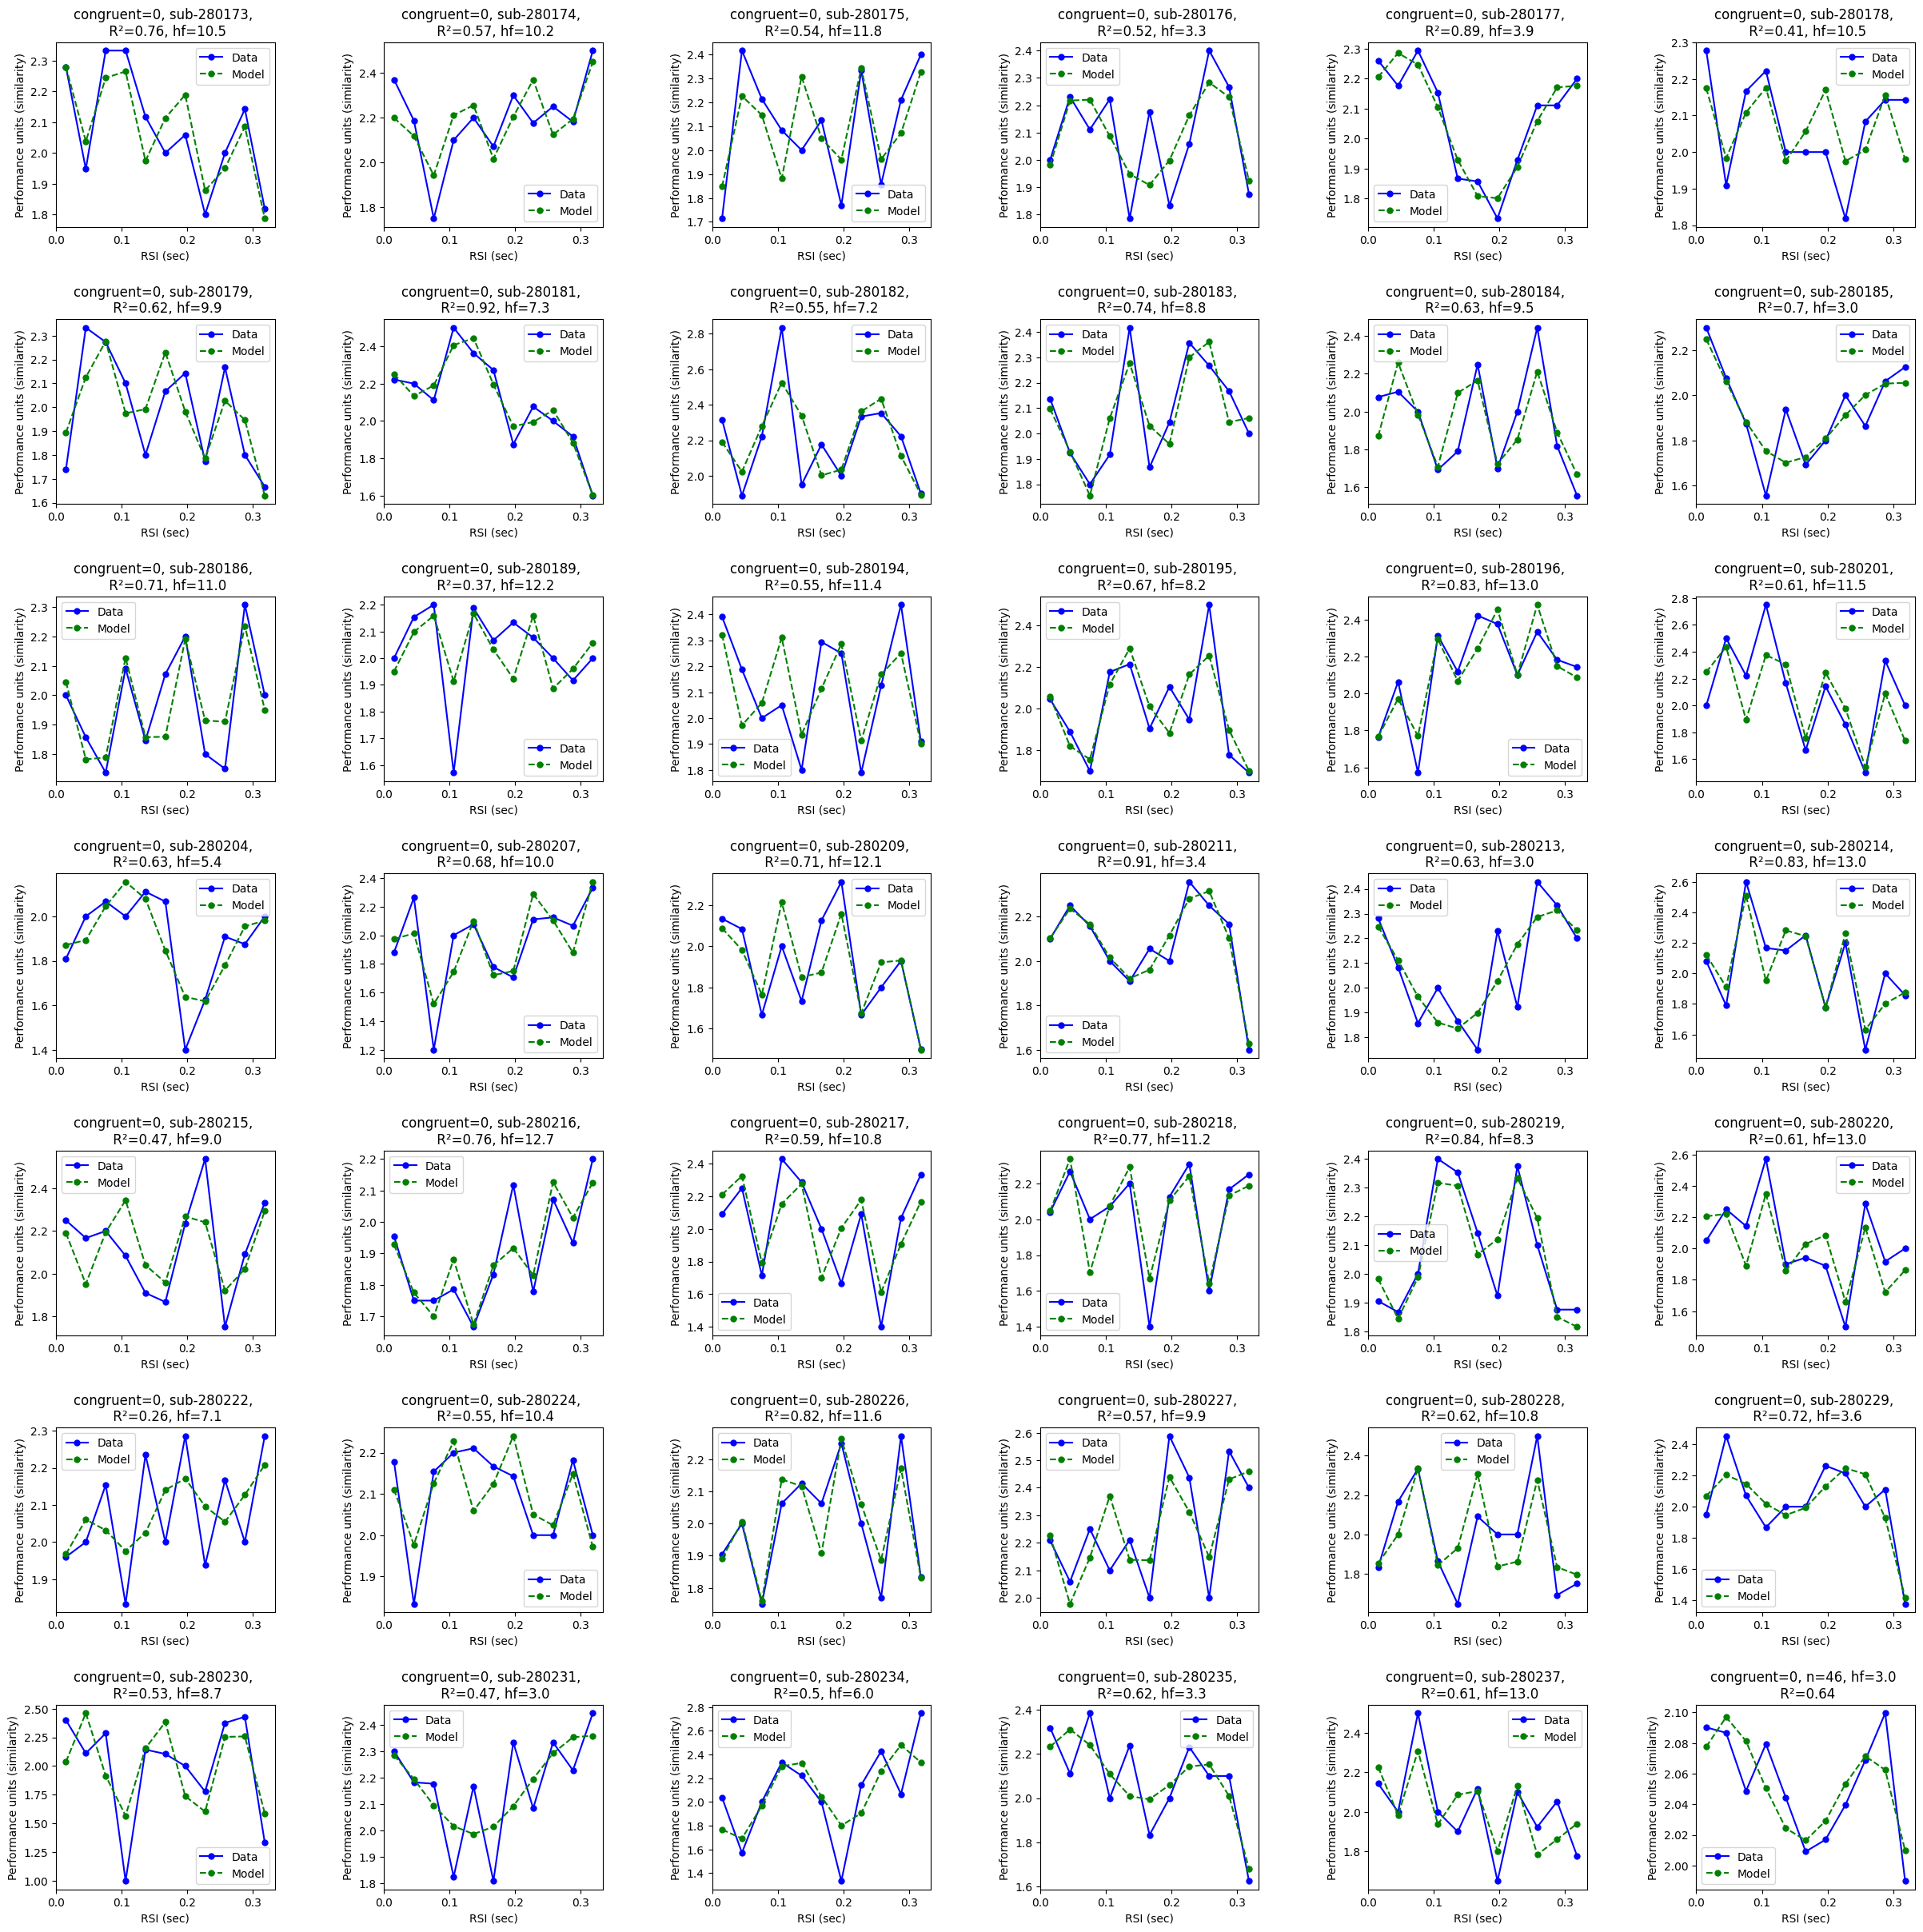

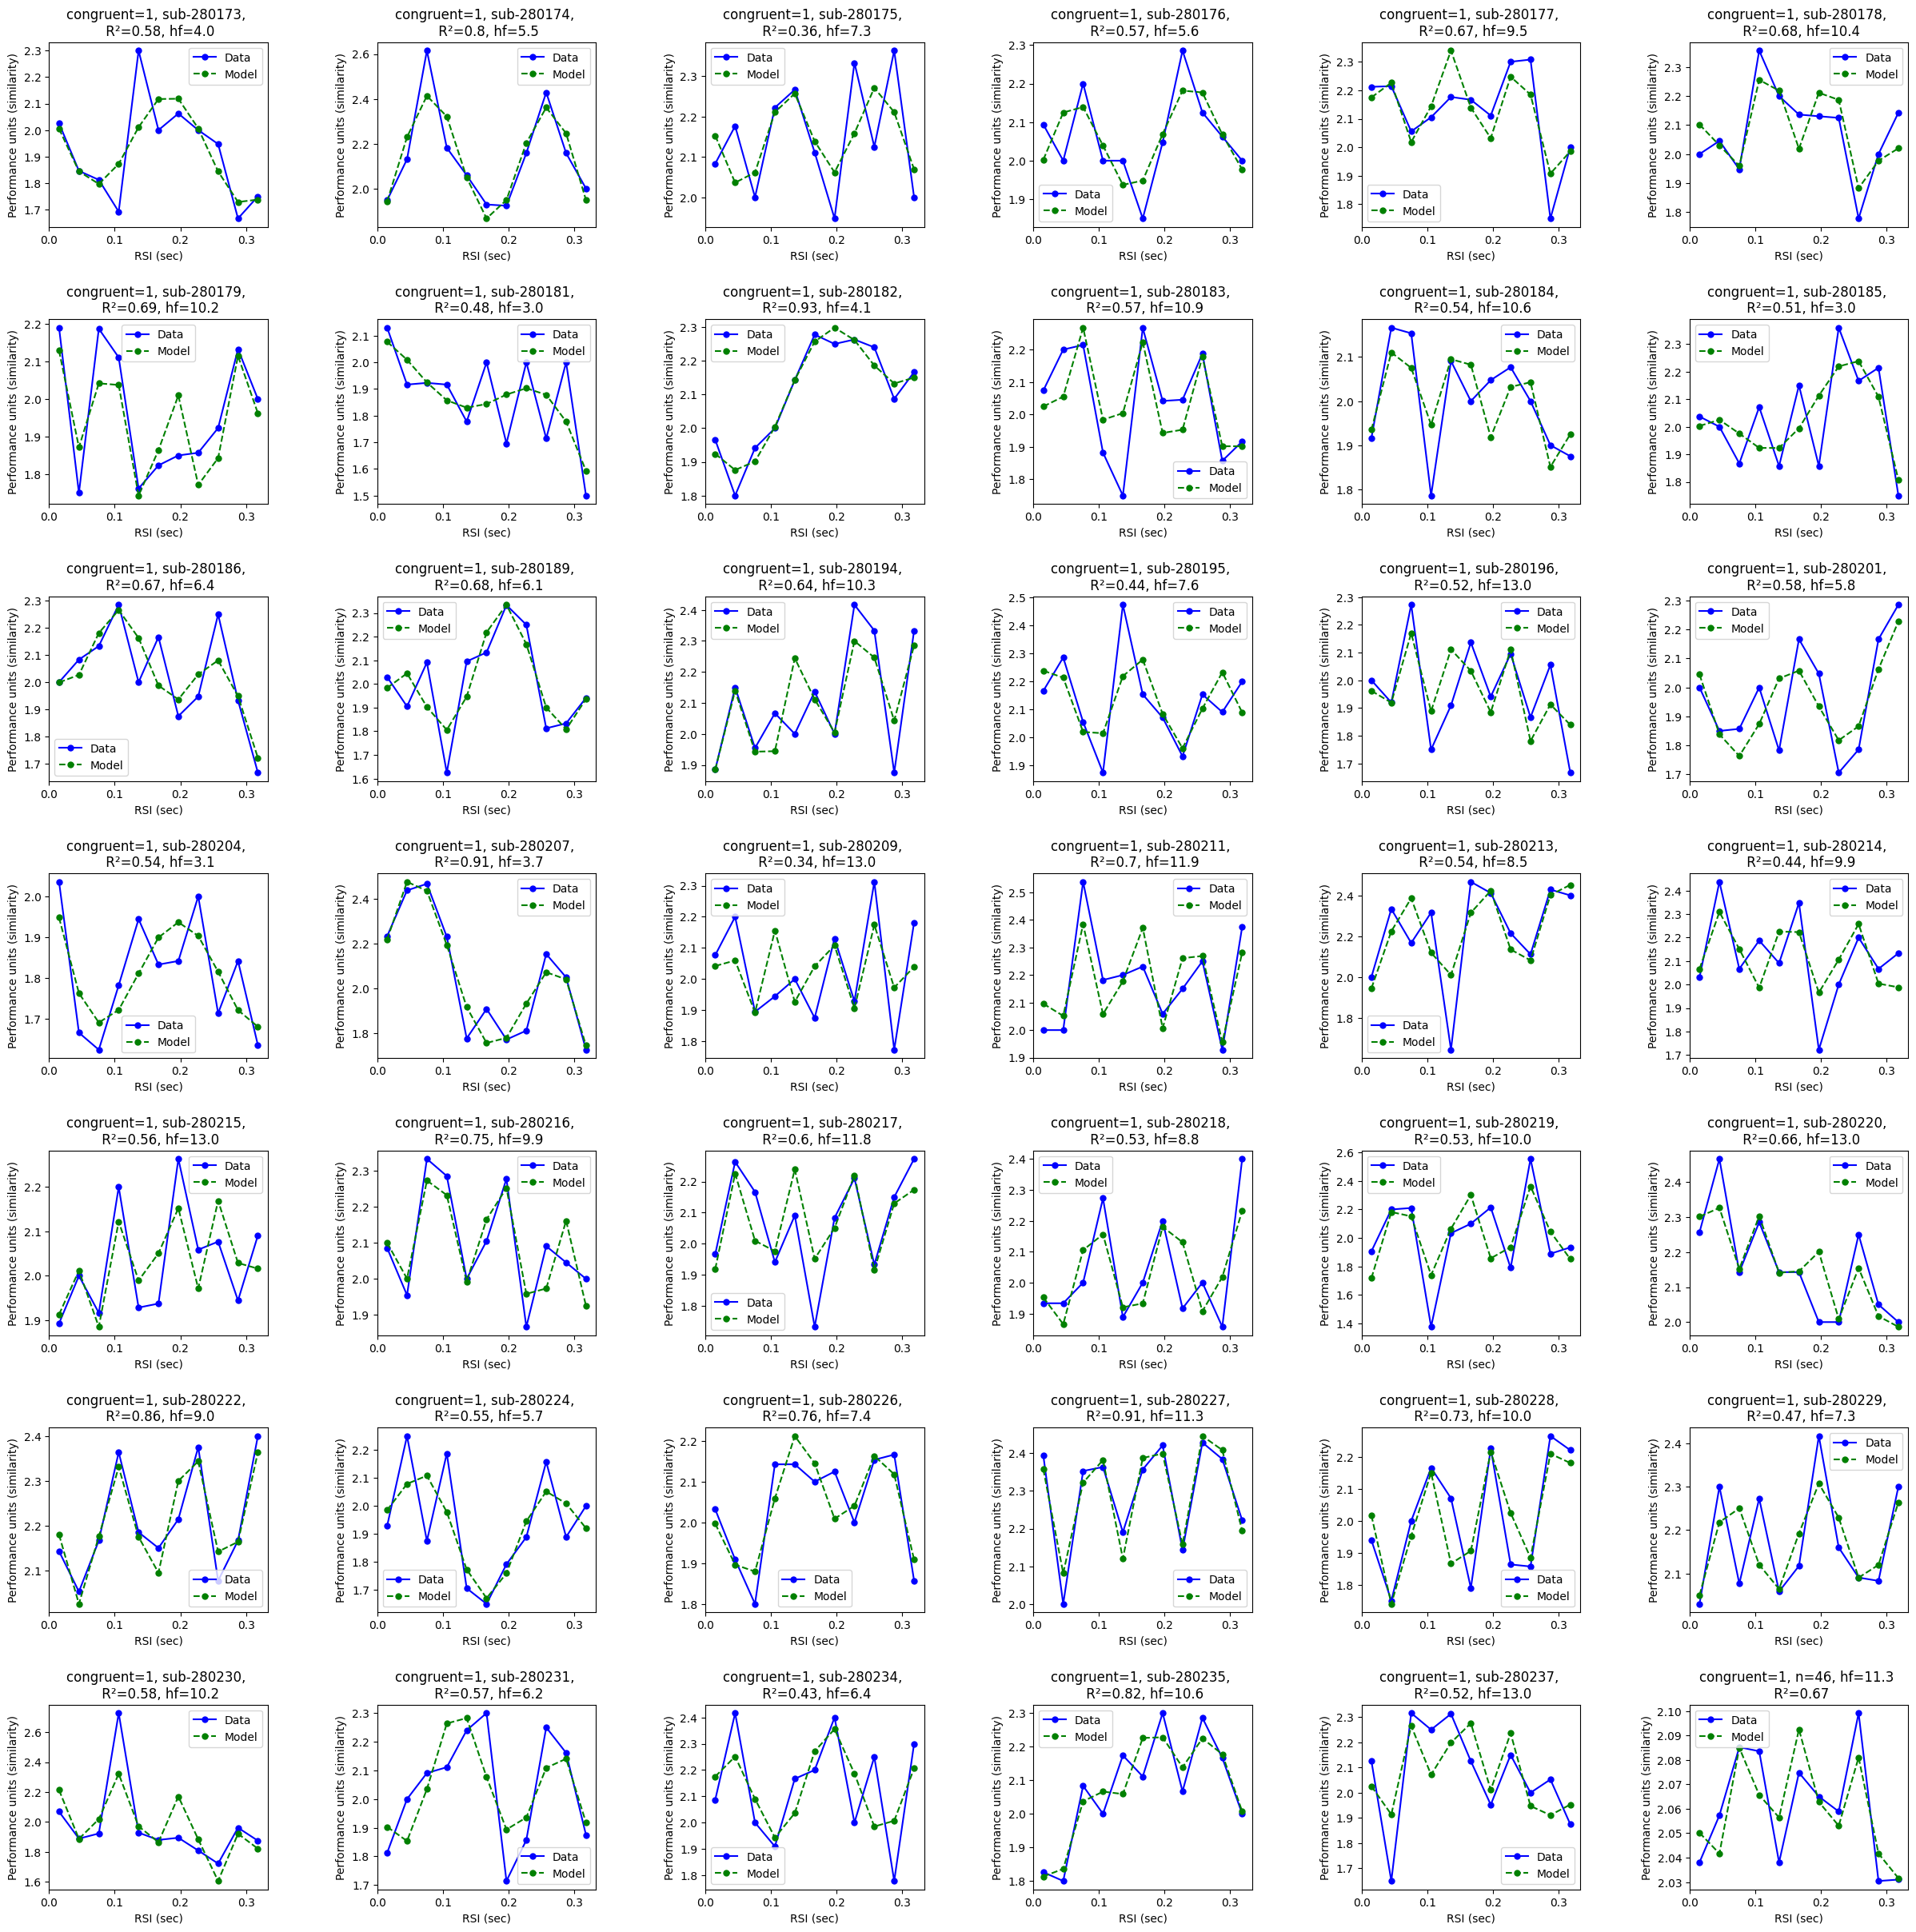

In [150]:
# fit a curve to a single condition

# Define bounds for the parameters
if output_var == "similarity":
    bounds=([-1, -1, -2, -1, -1, 3, -2],  # Lower bounds
            [1, 1, 2, 1, 1, 13, 2])
elif output_var == "hr":
    bounds=([-0.5, -0.5, -2, -0.5, -0.5, 3, -1],  # Lower bounds
            [0.5, 0.5, 2, 0.5, 0.5, 13, 1])


# trial_type = 0
n_iter=10

for trial_type in [0,1]:
    # with PdfPages(path_pic+'{}-{}-{}-curve-fit.pdf'.format(df_var, trial_type, output_var)) as pdf:
    rows = 7
    cols = 6
    fig, axes = plt.subplots(rows, cols, figsize=(30, 30))
    axes = axes.flatten()
    # bin_labels = [int(i) for i in np.linspace(0, 333, num_bins+1)]
    for idx, p_data in enumerate(tqdm(agg_dfs)):
        if idx < len(axes):
            x_data = (p_data[p_data[df_var] == trial_type]['binned_jitter']) / 33 # Example x data (time points)
            y_data = p_data[p_data[df_var] == trial_type][output_var] 

            # Run the optimization 100 times with different initial values
            best_fit_params, best_r2, best_rel = run_optimization(x_data.to_numpy(), y_data.to_numpy(), bounds, n_iterations=n_iter)
            
            # print('Best fitted parameters:', best_fit_params)
            # print('Best residual:', best_r2)

            # Plot the results
            ax = axes[idx]
            line1 = ax.plot(x_data, y_data, 'Blue', label='Data', marker="o", ms=5)
            line2 = ax.plot(x_data, model(x_data, *best_fit_params), 'g', label='Model', marker="o", ms=5, linestyle="--")
            ax.legend(handles=[line1[0], line2[0]])
            ax.set_xlabel('RSI (sec)')
            ax.set_ylabel('Performance units ({})'.format(output_var))
            ax.set_title('{}={}, sub-{}, \n R²={}, hf={}'.format(df_var, trial_type, subjects[idx], np.round(best_r2, 2),
                                                               np.round(best_fit_params[5], 1)))
    ax = axes[idx+1]
    x_data = (avg_df[avg_df[df_var] == trial_type]['binned_jitter']) / 33 # Example x data (time points)
    y_data = avg_df[avg_df[df_var] == trial_type][output_var] 

    # Run the optimization 100 times with different initial values
    best_fit_params, best_r2, best_rel = run_optimization(x_data.to_numpy(), y_data.to_numpy(), bounds, n_iterations=n_iter)
    
    print('Best fitted parameters:', best_fit_params)
    print('Best residual:', best_r2)

    # Plot the results
    line1 = ax.plot(x_data, y_data, 'Blue', label='Data', marker="o", ms=5)
    line2 = ax.plot(x_data, model(x_data, *best_fit_params), 'g', label='Model', marker="o", ms=5, linestyle="--")
    
    ax.legend(handles=[line1[0], line2[0]])
    ax.set_xlabel('RSI (sec)')
    ax.set_ylabel('Performance units ({})'.format(output_var))
    ax.set_title('{}={}, n={}, hf={} \n R²={}'.format(df_var, trial_type, len(subjects), np.round(best_fit_params[5], 1),
                                                       np.round(best_r2, 2), 
                                                       ))
    for j in range(idx + 2, len(axes)):
        fig.delaxes(axes[j])
    # plt.title("Average (n={})".format(len(subjects)))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # pdf.savefig(fig)

bin 15.1 ms, p = 0.1773
bin 45.4 ms, p = 0.5444
bin 75.7 ms, p = 0.5449
bin 106.0 ms, p = 0.9543
bin 136.2 ms, p = 0.8825
bin 166.5 ms, p = 0.1476
bin 196.8 ms, p = 0.3057
bin 227.0 ms, p = 0.6492
bin 257.3 ms, p = 0.5612
bin 287.6 ms, p = 0.0636
bin 317.9 ms, p = 0.4855


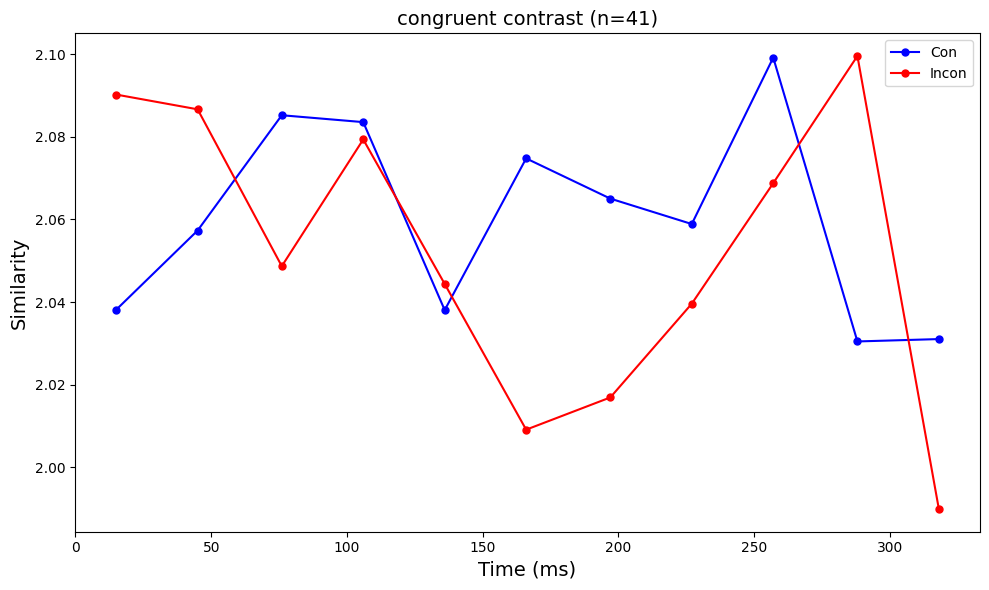

In [146]:
all_data = pd.DataFrame()
p_vals = []
for bin in list(agg_dfs[0]["binned_jitter"].unique()):
    con_data = []
    incon_data = []
    for dataf in agg_dfs:
        con_data.append(dataf[(dataf[df_var] == 1) & (dataf["binned_jitter"] == bin)][output_var].mean())
        incon_data.append(dataf[(dataf[df_var] == 0) & (dataf["binned_jitter"] == bin)][output_var].mean())
    p_val = np.round(stats.ttest_rel(con_data, incon_data, nan_policy="omit")[1], 4)
    print("bin {} ms, p = {}".format(np.round(333/11*bin, 1), p_val))
    p_vals.append(p_val)

# Plot the results
pic_name = "{}-{}-contrast.png".format(df_var, output_var)
cluster_step = 10
fig, ax = plt.subplots(figsize=(10, 6))
times = avg_df[avg_df[df_var] == 1]['binned_jitter'].to_numpy()
times = [np.round(333/11*i, 0) for i in times]
con_data = avg_df[avg_df[df_var] == 1]["similarity"]
incon_data = avg_df[avg_df[df_var] == 0]["similarity"]
# Plot condition 1 (congruent) and condition 2 (incongruent)
ax.plot(times, con_data, label='Con', color='Blue', marker='o', ms=5,)
ax.plot(times, incon_data, label='Incon', color='Red', marker='o', ms=5,)

# Highlight significant regions where p_val < 0.05
for i in range(len(p_vals)):
    if p_vals[i] < 0.05:
        start = times[i] - cluster_step  # Shift left
        end = times[i] + cluster_step  # Shift right
        ax.axvspan(start, end, color='red', alpha=0.3, label = "p<0.05")

# Labels and title
ax.set_title(f'{df_var} contrast (n={len(agg_dfs)})', fontsize=14)
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel('Similarity', fontsize=14)
ax.legend()

# Show plot
plt.tight_layout()
# plt.show()
# plt.savefig(path_pic + "{}".format(pic_name))

In [144]:
len(trial_data_list)

41

## FFT